In [2]:
import os
import pandas as pd
import numpy as np
from skopt import BayesSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import datetime

In [3]:
csv_dir = '../../SEC Trackman Data/'
all_files = [os.path.join(csv_dir, f) for f in os.listdir(csv_dir) if f.endswith('.csv')]

df_list = []

for file in all_files:
    df = pd.read_csv(file)
    df_list.append(df)

all_pitches = pd.concat(df_list, ignore_index=True)

print(all_pitches.shape)
print(all_pitches.columns)

(270589, 167)
Index(['PitchNo', 'Date', 'Time', 'PAofInning', 'PitchofPA', 'Pitcher',
       'PitcherId', 'PitcherThrows', 'PitcherTeam', 'Batter',
       ...
       'ThrowTrajectoryZc1', 'ThrowTrajectoryZc2', 'PitchReleaseConfidence',
       'PitchLocationConfidence', 'PitchMovementConfidence',
       'HitLaunchConfidence', 'HitLandingConfidence',
       'CatcherThrowCatchConfidence', 'CatcherThrowReleaseConfidence',
       'CatcherThrowLocationConfidence'],
      dtype='object', length=167)


In [4]:
fc = all_pitches[all_pitches['TaggedPitchType']=='Cutter']
print(fc.shape)

(8203, 167)


In [5]:
fc['whiff'] = np.where(fc['PitchCall']=='StrikeSwinging',1,0)

C:\Users\charl\AppData\Local\Temp\ipykernel_14688\1525590373.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fc['whiff'] = np.where(fc['PitchCall']=='StrikeSwinging',1,0)


In [6]:
preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']

In [7]:
fc_X = fc[preds]
fc_y = fc['whiff']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(fc_X, fc_y, test_size=.33, random_state=25)

# Set up the XGBoost model
xgb_model = XGBClassifier(random_state=25)

# Define the parameter space for Bayesian hyperparameter tuning for XGBoost
param_space = {
    'learning_rate': (0.01, 0.3, 'log-uniform'),  # Learning rate
    'max_depth': (3, 10),  # Maximum depth of a tree
    'n_estimators': (50, 300),  # Number of boosting rounds
    'subsample': (0.6, 1.0),  # Subsample ratio of the training instances
    'colsample_bytree': (0.6, 1.0),  # Subsample ratio of columns for each tree
    'gamma': (0, 10),  # Minimum loss reduction required to make a further partition
    'reg_alpha': (1e-8, 1.0, 'log-uniform'),  # L1 regularization term
    'reg_lambda': (1e-8, 1.0, 'log-uniform'),  # L2 regularization term
}

# Set up Bayesian search using BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=xgb_model,
    search_spaces=param_space,
    n_iter=25,  # Number of iterations
    cv=3,  # 3-fold cross-validation
    scoring='accuracy',  # Scoring metric
    n_jobs=-1,  # Use all available cores
    verbose=0,
    random_state=42
)

# Fit the model using Bayesian hyperparameter tuning
bayes_search.fit(X_train, y_train)

# Best hyperparameters found
best_params = bayes_search.best_params_
print(f"Best hyperparameters for Whiffs: {best_params}")

# Make predictions on the training and test sets using the best model
best_model = bayes_search.best_estimator_
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Calculate MSE and R-squared for both training and test sets
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)
auc_train = roc_auc_score(y_train, y_train_pred)
auc_test = roc_auc_score(y_test, y_test_pred)

print(f'Accuracy (Training): {accuracy_train:.4f}')
print(f'ROC AUC (Training): {auc_train:.4f}')
print(f'Accuracy (Test): {accuracy_test:.4f}')
print(f'ROC AUC (Test): {auc_test:.4f}')

Best hyperparameters for Whiffs: OrderedDict([('colsample_bytree', 0.9349553422213137), ('gamma', 9), ('learning_rate', 0.02806554771929606), ('max_depth', 10), ('n_estimators', 266), ('reg_alpha', 3.151399971510153e-08), ('reg_lambda', 1.2778159542148633e-07), ('subsample', 0.7414349590513672)])
Accuracy (Training): 0.8561
ROC AUC (Training): 0.5019
Accuracy (Test): 0.8386
ROC AUC (Test): 0.5000


ROC AUC: 0.5000


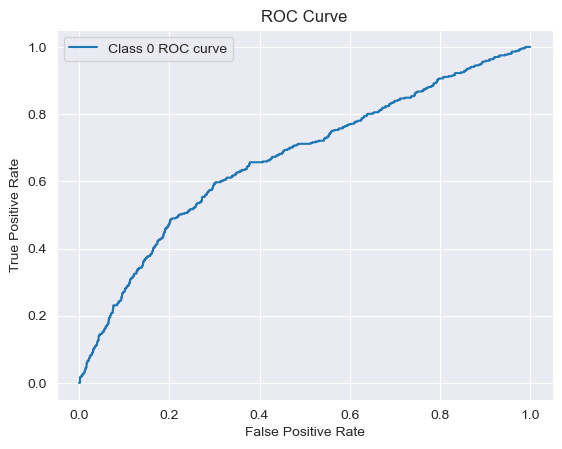

In [9]:
y_pred_prob = best_model.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, y_test_pred, multi_class='ovr')

print(f'ROC AUC: {roc_auc:.4f}')

# Plotting ROC Curve for one class (e.g., class 0)
fpr, tpr, _ = roc_curve(y_test == 1, y_pred_prob)
plt.plot(fpr, tpr, label='Class 0 ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

In [10]:
fc['Date'] = pd.to_datetime(fc['Date'], format = 'mixed')
aub_fc_2024 = fc[(fc['PitcherTeam']=='AUB_TIG') & (fc['Date'] > datetime.datetime(2024,1,1))]

C:\Users\charl\AppData\Local\Temp\ipykernel_14688\2871686739.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fc['Date'] = pd.to_datetime(fc['Date'], format = 'mixed')


In [11]:
# Get unique values
unique_values = fc['Pitcher'].unique()
aub_unique_values = aub_fc_2024['Pitcher'].unique()

print(aub_unique_values)

# Create a dictionary to store subsets
all_subsets = {value: fc[fc['Pitcher'] == value] for value in unique_values}

aub_subsets = {value: aub_fc_2024[aub_fc_2024['Pitcher'] == value] for value in aub_unique_values}

['McBride, Connor' 'Murphy, Hayden' 'Allsup, Chase' 'Schorr, Ben']


In [14]:
all_subsets['']

KeyError: 'Causey, AJ'

In [12]:
def aub_fc_stuff(name):
    
    preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']
    
    all_preds = best_model.predict_proba(fc_X)[:,1]
    mean_pred = np.mean(all_preds)

    pitcher = aub_subsets[name]
    pitcher_x = pitcher[preds]

    whiff_preds = best_model.predict_proba(pitcher_x)[:,1]

    stuff = whiff_preds/mean_pred
    
    print(f"{name} cutter stuff+: {np.mean(stuff * 100)}")

In [13]:
for player in aub_unique_values:
    aub_fc_stuff(player)

McBride, Connor cutter stuff+: 112.50302124023438
Murphy, Hayden cutter stuff+: 78.0311279296875
Allsup, Chase cutter stuff+: 83.24943542480469
Schorr, Ben cutter stuff+: 61.92625045776367


Splits 

In [ ]:
fc_rr = fc[(fc['PitcherThrows'] == 'Right') & (fc['BatterSide'] == 'Right')]
fc_rl = fc[(fc['PitcherThrows'] == 'Right') & (fc['BatterSide'] == 'Left')]
fc_lr = fc[(fc['PitcherThrows'] == 'Left') & (fc['BatterSide'] == 'Right')]
fc_ll = fc[(fc['PitcherThrows'] == 'Left') & (fc['BatterSide'] == 'Left')]

print(fc_rr.shape)
print(fc_rl.shape)
print(fc_lr.shape)
print(fc_ll.shape)

In [ ]:
fc_rr['whiff'] = np.where(fc_rr['PitchCall']=='StrikeSwinging',1,0)
fc_rl['whiff'] = np.where(fc_rl['PitchCall']=='StrikeSwinging',1,0)
fc_lr['whiff'] = np.where(fc_lr['PitchCall']=='StrikeSwinging',1,0)
fc_ll['whiff'] = np.where(fc_ll['PitchCall']=='StrikeSwinging',1,0)

In [ ]:
preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']

In [ ]:
fc_rr_X = fc_rr[preds]
fc_rr_y = fc_rr['whiff']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(fc_rr_X, fc_rr_y, test_size=.33, random_state=25)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
aub_fc_rr = fc_rr[fc_rr['PitcherTeam']=='AUB_TIG']
print(aub_fc_rr.shape)

In [ ]:
# Get unique values
unique_values = fc_rr['Pitcher'].unique()
aub_unique_values = aub_fc_rr['Pitcher'].unique()

print(aub_unique_values)

# Create a dictionary to store subsets
all_subsets = {value: fc_rr[fc_rr['Pitcher'] == value] for value in unique_values}

aub_subsets = {value: fc_rr[fc_rr['Pitcher'] == value] for value in aub_unique_values}

In [ ]:
def aub_rr_fc_stuff(name):
    
    preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']
    
    all_preds = model.predict_proba(fc_rr_X)[:,1]
    mean_pred = np.mean(all_preds)

    pitcher = aub_subsets[name]
    pitcher_x = pitcher[preds]

    whiff_preds = model.predict_proba(pitcher_x)[:,1]

    stuff = whiff_preds/mean_pred
    
    print(f"{name} RR Cutter stuff+: {np.mean(stuff * 100)}")

In [ ]:
for pitcher in aub_unique_values:
    aub_rr_fc_stuff(pitcher)

In [ ]:
fc_rl_X = fc_rl[preds]
fc_rl_y = fc_rl['whiff']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(fc_rl_X, fc_rl_y, test_size=.33, random_state=25)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
aub_fc_rl = fc_rl[fc_rl['PitcherTeam']=='AUB_TIG']
print(aub_fc_rl.shape)

In [ ]:
# Get unique values
unique_values = fc_rl['Pitcher'].unique()
aub_unique_values = aub_fc_rl['Pitcher'].unique()

print(aub_unique_values)

# Create a dictionary to store subsets
all_subsets = {value: fc_rl[fc_rl['Pitcher'] == value] for value in unique_values}

aub_subsets = {value: fc_rl[fc_rl['Pitcher'] == value] for value in aub_unique_values}

In [ ]:
def aub_rl_fc_stuff(name):
    
    preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']
    
    all_preds = model.predict_proba(fc_rl_X)[:,1]
    mean_pred = np.mean(all_preds)

    pitcher = aub_subsets[name]
    pitcher_x = pitcher[preds]

    whiff_preds = model.predict_proba(pitcher_x)[:,1]

    stuff = whiff_preds/mean_pred
    
    print(f"{name} RL Cutter stuff+: {np.mean(stuff * 100)}")

In [ ]:
for pitcher in aub_unique_values:
    aub_rl_fc_stuff(pitcher)

In [ ]:
fc_lr_X = fc_lr[preds]
fc_lr_y = fc_lr['whiff']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(fc_lr_X, fc_lr_y, test_size=.33, random_state=25)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
aub_fc_lr = fc_lr[fc_lr['PitcherTeam']=='AUB_TIG']
print(aub_fc_lr.shape)

In [ ]:
# Get unique values
unique_values = fc_lr['Pitcher'].unique()
aub_unique_values = aub_fc_lr['Pitcher'].unique()

print(aub_unique_values)

# Create a dictionary to store subsets
all_subsets = {value: fc_lr[fc_lr['Pitcher'] == value] for value in unique_values}

aub_subsets = {value: fc_lr[fc_lr['Pitcher'] == value] for value in aub_unique_values}

In [ ]:
def aub_lr_fc_stuff(name):
    
    preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']
    
    all_preds = model.predict_proba(fc_lr_X)[:,1]
    mean_pred = np.mean(all_preds)

    pitcher = aub_subsets[name]
    pitcher_x = pitcher[preds]

    whiff_preds = model.predict_proba(pitcher_x)[:,1]

    stuff = whiff_preds/mean_pred
    
    print(f"{name} LR Cutter stuff+: {np.mean(stuff * 100)}")

In [ ]:
for pitcher in aub_unique_values:
    aub_lr_fc_stuff(pitcher)

In [ ]:
fc_ll_X = fc_ll[preds]
fc_ll_y = fc_ll['whiff']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(fc_ll_X, fc_ll_y, test_size=.33, random_state=25)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
aub_fc_ll = fc_ll[fc_ll['PitcherTeam']=='AUB_TIG']
print(aub_fc_ll.shape)

In [ ]:
# Get unique values
unique_values = fc_ll['Pitcher'].unique()
aub_unique_values = aub_fc_ll['Pitcher'].unique()

print(aub_unique_values)

# Create a dictionary to store subsets
all_subsets = {value: fc_ll[fc_ll['Pitcher'] == value] for value in unique_values}

aub_subsets = {value: fc_ll[fc_ll['Pitcher'] == value] for value in aub_unique_values}

In [ ]:
def aub_ll_fc_stuff(name):
    
    preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']
    
    all_preds = model.predict_proba(fc_ll_X)[:,1]
    mean_pred = np.mean(all_preds)

    pitcher = aub_subsets[name]
    pitcher_x = pitcher[preds]

    whiff_preds = model.predict_proba(pitcher_x)[:,1]

    stuff = whiff_preds/mean_pred
    
    print(f"{name} LL Cutter stuff+: {np.mean(stuff * 100)}")

In [ ]:
for pitcher in aub_unique_values:
    aub_ll_fc_stuff(pitcher)

In [ ]:
aub_subsets['Vail, Tommy']